In [244]:
import matplotlib.pyplot as plt
import numpy as nm
import pandas as pd
import math
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import defaultdict

In [245]:
folder = 'C:\\Users\\vswen\\Documents\\1. Biomedische Technologie\\BMT JAAR 5\\Kwart 4\\4. Data\\CTRPv2.0_2015_ctd2_ExpandedDataset\\'

# Import data
complete_df = pd.read_csv(f"{folder}CHEMBL2971_Ki.csv", sep=",")
# complete_df.fillna(complete_df.mean(), inplace=True)

In [246]:
smiles_list = complete_df['smiles']
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
scaffolds = [MurckoScaffold.GetScaffoldForMol(mol) for mol in mols]
scaffold_smiles = [Chem.MolToSmiles(scaffold) for scaffold in scaffolds]
scaffold_smiles = list(map(str, scaffold_smiles))

In [247]:
# Fingerprint aanmaken
molecules = [Chem.MolFromSmiles(smile) for smile in complete_df['smiles'].tolist()]
ecfp = [AllChem.GetMorganFingerprintAsBitVect(molecule,2,nBits=1024) for molecule in molecules]
complete_df['ecfp_bit_vectors'] = [[int(bit) for bit in keys.ToBitString()] for keys in ecfp]
complete_df['ECFP'] = [''.join(str(value) for value in row) for row in complete_df['ecfp_bit_vectors']]
complete_df.to_csv(f"{folder}chembl234_ki.csv", sep=',', index=False)

In [248]:
complete_df['ecfp_bit_vectors'].iloc[0]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [249]:
def get_unique_scaffolds(scaffold_smiles):
    unique_scaffolds = []
    for scaffold in scaffold_smiles:
        if scaffold not in unique_scaffolds:
            unique_scaffolds.append(scaffold)
    return unique_scaffolds

list_unique_scaffolds=get_unique_scaffolds(scaffold_smiles)

location_scaffolds = defaultdict(list)
for scaffold in scaffold_smiles:
    location_scaffolds[scaffold].append(scaffold)

def location_similar_scaffolds(lijst):
    locations = defaultdict(list)
    for index, item in enumerate(lijst):
        if lijst.count(item) > 1:
            locations[item].append(index)
    return dict(locations)

locations_similar_scaffolds = location_similar_scaffolds(scaffold_smiles)

df_scaffolds_grouped = pd.DataFrame(columns=['Compound', 'Scaffold', 'Recurring'])
rows=[]
symbol_mapping = {}
symbol_counter = 0

for i, compound in enumerate(smiles_list):
    scaffold = scaffold_smiles[i]

    if scaffold in locations_similar_scaffolds:
        if scaffold not in symbol_mapping:
            symbol_counter += 1
            symbol_mapping[scaffold] = symbol_counter

        recurring_symbol = symbol_mapping[scaffold]
        recurring = True
    else:
        recurring_symbol = 0
        recurring = False
    row = [compound, scaffold, recurring_symbol]
    rows.append(row)

df_scaffolds_grouped = pd.DataFrame(rows, columns=['cpd_smiles', 'spd_scaffold', 'recurring_scaffold'])

#Toevoegen van extra data die nodig is voor de modellen
df_scaffolds_grouped.insert(0,'y',complete_df['y'])
# df_scaffolds_grouped.insert(1,'ecfp_bit_vectors',complete_df['ecfp_bit_vectors']) 
df_scaffolds_grouped['ecfp_bit_vectors'] = complete_df['ecfp_bit_vectors'].apply(lambda x: ''.join(str(i) for i in x))

df_scaffolds_grouped_sorted = df_scaffolds_grouped.sort_values('recurring_scaffold', ascending=False)

df_scaffolds_grouped_sorted.to_csv(f"{folder}scaffold_split_test.txt", sep='\t', index=False)


In [250]:
total_length_compounds = len(complete_df)
size_train_set = total_length_compounds * 0.8 # Uitgaande van idealiter een 0.8:0.2 verhouding tussen train en test

In [251]:
# Import data
complete_df = pd.read_csv(f"{folder}scaffold_split_test.txt", sep="\t")

import random
# Data selecteren om een vergelijkbare data grootte te creeeren
random_indices = random.sample(range(len(complete_df)), 379)
complete_df = complete_df.iloc[random_indices]

complete_df['ecfp_bit_vectors'] = complete_df['ecfp_bit_vectors'].apply(lambda x: [int(i) for i in x])


In [252]:
#import random
# Data selecteren om een vergelijkbare data grootte te creeeren
#random_indices = random.sample(range(len(complete_df)), 400)
#selected_data = complete_df.iloc[random_indices]
#print len((selected_data)

# Dependent & Independent variable
# complete_df['ecfp_bit_vectors_kort'] = selected_data['ecfp_bit_vectors'].tolist() #Voorheen: complete_df['ecfp_bit_vectors']
# complete_df['y_kort'] = selected_data['y'].values #Voorheen: complete_df['y']

In [253]:
# Creeer een DF voor alle scaffolds die uniek zijn
df_unique_scaffolds = complete_df[complete_df['recurring_scaffold'] == 0]
df_unique_scaffolds = df_unique_scaffolds[['recurring_scaffold', 'ecfp_bit_vectors', 'y']]

# Extraheer de X en Y value van de nieuwe DF 
## X is de te gebruike compound waarde  | Fingerprint ECFP
## Y is de te voorspellen compound waarde | Ec50 Molair Logtransformed
x_unique = nm.array(df_unique_scaffolds['ecfp_bit_vectors'].tolist())
y_unique = df_unique_scaffolds['y'].values

In [254]:
# Creeer een DF voor alle scaffolds die meermaals voorkomen
df_grouped_scaffolds = complete_df[complete_df['recurring_scaffold'] > 0]
df_grouped_scaffolds = df_grouped_scaffolds[['ecfp_bit_vectors', 'y', 'recurring_scaffold']]

# Extraheer de X, Y en Z value van de nieuwe DF
## X is de te gebruike compound waarde  | Fingerprint ECFP
## Y is de te voorspellen compound waarde | Ec50 Molair Logtransformed
## Z is de indicator voor overeenkomstige scaffold groepen | Elke scaffoldgroup een eigen numerieke waarde
x_grouped = nm.array(df_grouped_scaffolds['ecfp_bit_vectors'].tolist())
y_grouped = df_grouped_scaffolds['y'].values
z_grouped = df_grouped_scaffolds['recurring_scaffold'].values.tolist()
print(x_grouped)

#df_grouped_scaffolds_indexes = df_grouped_scaffolds.groupby('recurring_scaffold')

[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


In [255]:
size_train_set_grouped_scaffolds = len(z_grouped) * 0.8
size_train_set_grouped_scaffolds = int(size_train_set_grouped_scaffolds)
print(size_train_set_grouped_scaffolds)

176


In [256]:
# Creeeren van lege lijsten voor de Grouped Scaffolds
x_train_grouped = []
y_train_grouped = []
x_test_grouped = []
y_test_grouped = []

In [257]:
for x in range(len(z_grouped)):
    if x < size_train_set_grouped_scaffolds:
        x_train_grouped.append(x_grouped[x])
        y_train_grouped.append(y_grouped[x])
    elif z_grouped[x] == z_grouped[x-1]:
        x_train_grouped.append(x_grouped[x])
        y_train_grouped.append(y_grouped[x])
    else: 
        remaining = len(z_grouped)-x
        break
        
for x in range(remaining):
    x_test_grouped.append(x_grouped[x+remaining])
    y_test_grouped.append(y_grouped[x+remaining])

In [258]:
print(len(x_train_grouped))
print(len(x_test_grouped))
print(y_train_grouped[0:5])
print(y_test_grouped[0:5])

176
45
[-2.7596678446896306, -3.100001582801352, -2.113943352306837, -3.57978359661681, -0.1367205671564068]
[0.958607314841775, 0.3279021420642826, 0.3372421683184259, 0.0809219076239261, -2.315970345456918]


In [259]:
print(x_train_grouped[0])
#x_train_grouped = [element.replace(' ', '').replace(',', '') for element in x_train_grouped]
# x_train_unique = [eval(element) for element in x_train_unique]

#x_train_grouped = [list(arr) for arr in x_train_grouped]
#print(x_train_grouped[0])
#x_test_grouped = [list(arr) for arr in x_test_grouped]

[0 0 1 ... 0 0 0]


In [260]:
from sklearn.model_selection import train_test_split
x_train_unique,x_test_unique,y_train_unique,y_test_unique=train_test_split(x_unique,y_unique,test_size=0.2, random_state=42)

In [261]:
#print(x_train_unique)
# print(x_train_unique[0])

x_train_unique = [list(arr) for arr in x_train_unique]
x_test_unique = [list(arr) for arr in x_test_unique]
#print(x_test_unique[0])

In [262]:
x_train = nm.concatenate((x_train_grouped, x_train_unique))
x_test = nm.concatenate((x_test_grouped, x_test_unique))

y_train = nm.concatenate((y_train_grouped, y_train_unique))
y_test = nm.concatenate((y_test_grouped, y_test_unique))

In [263]:
print('TRAIN DATA')
print('y_train', len(y_train), y_train)
print('x_train', len(x_train), x_train)

print('TEST DATA')
print('x_test', len(x_test), x_test)
print('y_test', len(y_test), y_test)

TRAIN DATA
y_train 302 [-2.75966784e+00 -3.10000158e+00 -2.11394335e+00 -3.57978360e+00
 -1.36720567e-01  8.23908741e-01 -2.32221929e+00 -3.46239800e+00
 -3.46352974e-01 -2.09999123e+00 -3.96199347e-01 -6.44579892e-02
 -2.04119983e-01 -3.16136800e+00 -2.32221929e+00 -1.76091259e-01
  5.85026652e-01 -3.14612804e+00 -3.07496038e-01  2.92429824e-01
  2.21848750e-01 -1.69019608e+00  4.08935393e-01 -3.23044892e+00
 -2.20000187e+00  9.69100130e-02 -2.69019608e+00 -3.38021124e+00
  2.07608311e-01  6.38272164e-01  4.43697499e-01 -5.14547753e-01
 -2.90000097e+00 -6.81858617e-02 -2.86923172e+00 -2.78532984e+00
 -1.20002927e+00  5.52841969e-01 -1.10589710e-01  8.86056648e-01
 -3.40000062e+00 -7.55874856e-01 -2.69019608e+00  2.51811973e-01
 -1.28555731e+00  9.58607315e-01  3.27902142e-01  3.37242168e-01
  8.09219076e-02 -2.31597035e+00 -4.00019635e-01 -2.17609126e+00
  8.86056648e-01  1.36677140e-01 -3.07496038e-01 -6.48360011e-01
  1.24938737e-01  2.29147988e-01 -2.34242268e+00 -1.60852603e+00
  

In [264]:

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=200, min_samples_split=5,min_samples_leaf=4,max_depth=10,bootstrap=True)
regressor.fit(x_train,y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=5,
                      n_estimators=200)

In [265]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=200, min_samples_split=5,min_samples_leaf=4,max_depth=10,bootstrap=True)
regressor.fit(x_train,y_train)

# Predict Test result
y_pred = regressor.predict(x_test)

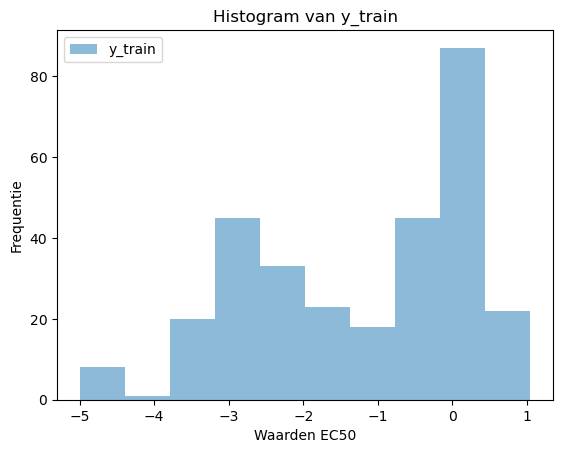

In [266]:
# Visualisatie y_train ## Vooral voor eigen begrip
plt.hist(y_train, alpha=0.5, label='y_train')
plt.xlabel('Waarden EC50')
plt.ylabel('Frequentie')
plt.title('Histogram van y_train')
plt.legend()
plt.show()

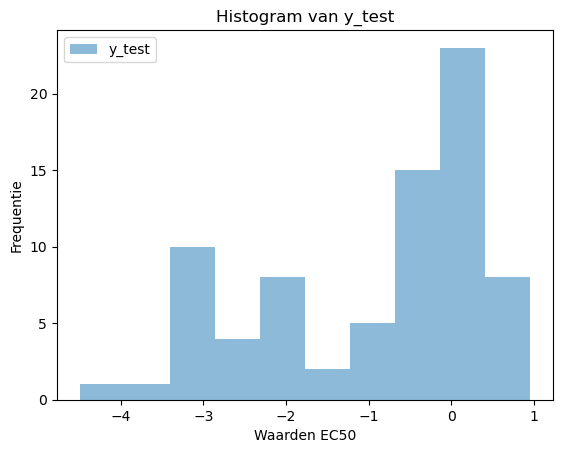

In [267]:
# Visualisatie y_test ## Vooral voor eigen begrip
plt.hist(y_test, alpha=0.5, label='y_test')
plt.xlabel('Waarden EC50')
plt.ylabel('Frequentie')
plt.title('Histogram van y_test')
plt.legend()
plt.show()

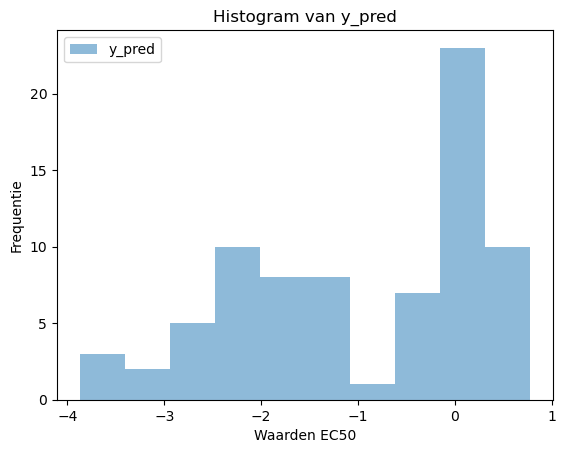

In [268]:
# Visualisatie y_pred ## Vooral voor eigen begrip
plt.hist(y_pred, alpha=0.5, label='y_pred')
plt.xlabel('Waarden EC50')
plt.ylabel('Frequentie')
plt.title('Histogram van y_pred')
plt.legend()
plt.show()

In [269]:
# Errors berekenen
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Mean Absolute Error
mae=mean_absolute_error(y_test, y_pred)
print('mean absolute error is ', mae)

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print('mean squared error is ', mse)

# Root Mean Squared Error
rmse = math.sqrt(mse)
print('root mean squared error is ', rmse)

# R2 berekenen
slope, intercept = nm.polyfit(y_test,y_pred,1)
line = slope * nm.array(y_test)+ intercept
r2 = r2_score(y_test, y_pred)
print('r2 is', r2)

mean absolute error is  0.41336659969268214
mean squared error is  0.47752749552415663
root mean squared error is  0.6910336428309092
r2 is 0.7483825778705198


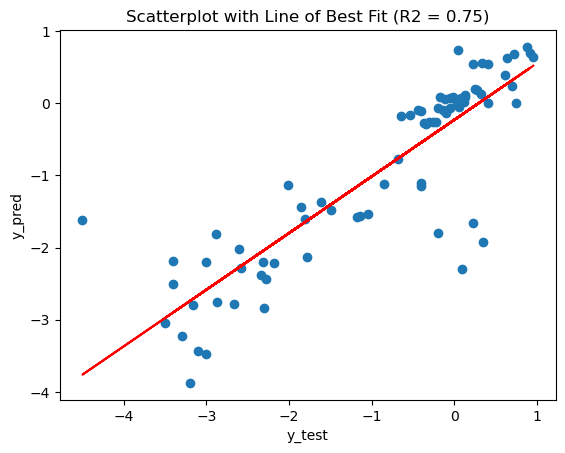

In [270]:
# R2 Visualisatie                                              
plt.scatter(y_test,y_pred)
plt.plot(y_test, line, color='red', label='line of current best fit')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title('Scatterplot with Line of Best Fit (R2 = {:.2f})'.format(r2))
plt.show()